## test image

In [ ]:
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread

def convert_tif_to_jpg(input_folder, output_folder):
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    tif_files = sorted([f for f in input_folder.iterdir() if f.suffix.lower() == '.tif'])

    for tif_file in tqdm(tif_files, desc="Converting .tif to .jpg"):
        # Read .tif image
        image = cv2.imread(str(tif_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Save as .jpg
        jpg_name = tif_file.stem + ".jpg"
        jpg_path = output_folder / jpg_name
        cv2.imwrite(str(jpg_path), image)

    print(f"\n✅ Converted {len(tif_files)} files to {output_folder}")

# === Example usage ===
if __name__ == "__main__":
    convert_tif_to_jpg("data/test_release", "data/test_img")


Converting .tif to .jpg: 100%|██████████| 101/101 [00:00<00:00, 125.01it/s]


✅ Converted 101 files to data/test_img


## convert Coco

In [ ]:
import os
import json
import glob
import cv2
import numpy as np
import skimage.io as sio
from collections import defaultdict

def generate_coco_json(root_dir, output_json):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 0
    annotation_id = 0
    category_ids_set = set()  

    folders = sorted(os.listdir(root_dir))
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        
        img_path = os.path.join(folder_path, "image.tif")
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: cannot read image {img_path}, skipping...")
            continue
        height, width = img.shape[:2]

        coco_output["images"].append({
            "file_name": os.path.relpath(img_path, root_dir),
            "height": height,
            "width": width,
            "id": image_id
        })

        mask_paths = glob.glob(os.path.join(folder_path, "class*.tif"))
        for mask_path in mask_paths:
            filename = os.path.basename(mask_path)
            category_id = int(filename.replace("class", "").replace(".tif", ""))
            category_ids_set.add(category_id)

            mask = sio.imread(mask_path)
            if mask is None:
                print(f"Warning: cannot read mask {mask_path}, skipping...")
                continue
            if len(mask.shape) == 3:
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = (mask > 0).astype(np.uint8)

            if mask.sum() == 0:
                continue  

            polygons = mask_to_polygons(mask)

            if len(polygons) == 0:
                continue  

            for poly in polygons:
                coco_output["annotations"].append({
                    "segmentation": [poly],
                    "iscrowd": 0,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": get_bbox_from_poly(poly),
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "id": annotation_id
                })
                annotation_id += 1

        image_id += 1

    for cid in sorted(category_ids_set):
        coco_output["categories"].append({
            "id": cid,
            "name": f"class{cid}",
            "supercategory": "none"
        })


    with open(output_json, "w") as f:
        json.dump(coco_output, f, indent=2)

def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        contour = contour.flatten().tolist()
        if len(contour) >= 6: 
            polygons.append(contour)
    return polygons

def get_bbox_from_poly(poly):
    poly = np.array(poly).reshape(-1, 2)
    x_min = np.min(poly[:, 0])
    y_min = np.min(poly[:, 1])
    x_max = np.max(poly[:, 0])
    y_max = np.max(poly[:, 1])
    return [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]

if __name__ == "__main__":
    generate_coco_json(
        root_dir="data/train",
        output_json="data/train.json"
    )


## visualize

🖼️ Image path: data/train/0088d6cd-fcbd-4037-babf-74abd3c82204/image.tif


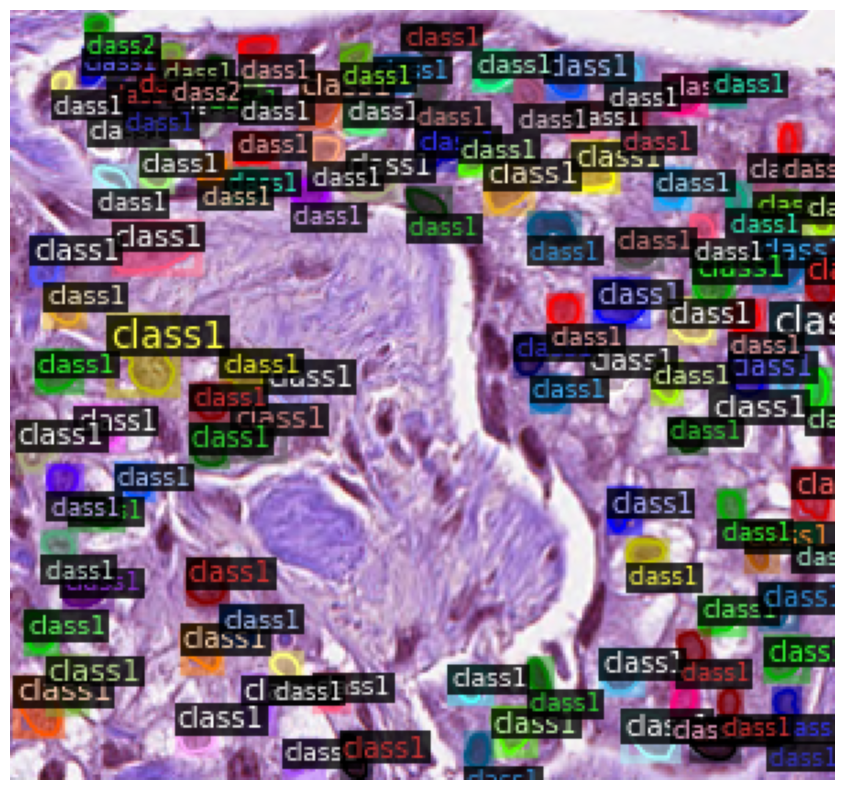

🖼️ Image path: data/train/013c63ee-de86-4fda-b195-041a4a303b2c/image.tif


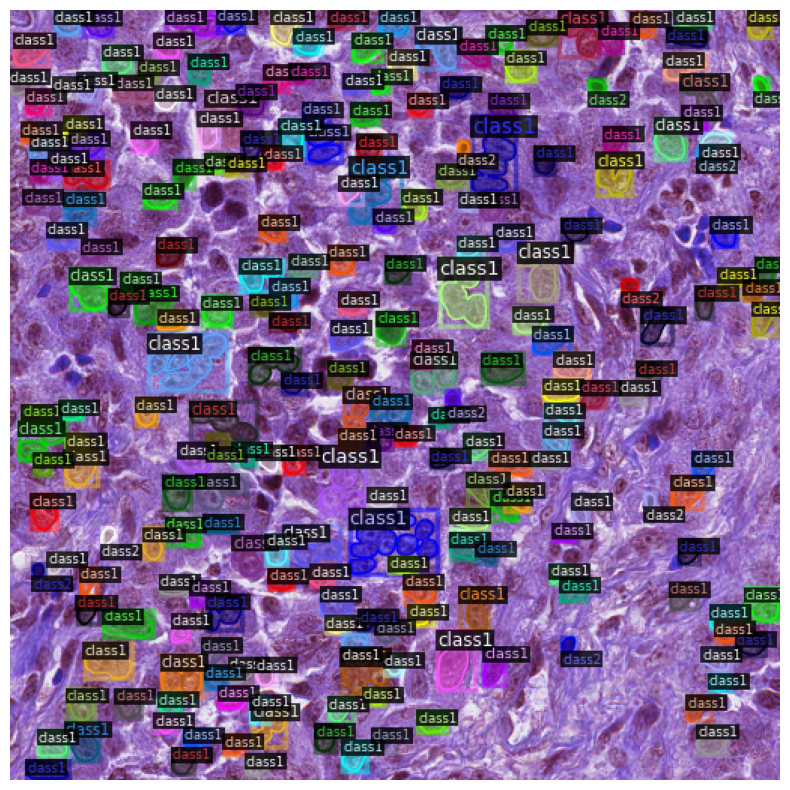

In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
import os
import cv2

# 1. Register the COCO dataset
register_coco_instances(
    "my_dataset_train",                 # Dataset name
    {},                                 # Empty metadata (optional)
    "data/train.json",                 # Path to COCO JSON
    "data/train"                       # Path to image directory
)

# 2. Load metadata and dataset
metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

# 3. Visualize the first 2 images
for d in sorted(dataset_dicts, key=lambda x: x["file_name"])[:2]:
    img_path = d["file_name"]
    print(f"🖼️ Image path: {img_path}")
    img = cv2.imread(img_path)

    if img is None:
        print(f"❌ Failed to load image: {img_path}")
        continue

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.5,
        instance_mode=ColorMode.IMAGE_BW
    )

    out = visualizer.draw_dataset_dict(d)

    plt.figure(figsize=(10, 8))
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.tight_layout()
    plt.show()
